In [1]:
# import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
img=np.random.rand(1,1,10,10)
ker=np.random.rand(1,1,3,3)

In [3]:
# '''
# All the cooresponding receptive feilds locations are stored in a cloumn in matrix
# 00  01 ....
# 01  02 ....
# 02  03 ....   ____________________
# 10  11 ....   |  00 |  01 |  02  |
# 11  12 ....   |-----|-----|------| 
# 12  13 ....   |  10 |  11 |  12  |
# 20  21 ....   |-----|-----|------|
# 21  22 ....   |  20 |  21 |  22  |             
# 22  23 ....   |_____|_____|______|                   
# '''

In [4]:
def conv(img, ker, b, pad=1, stride=1):
    img_ba, img_dep, img_h, img_w= img.shape
    ker_ba, ker_dep, ker_h, ker_w= ker.shape
    
    out_h= int((img_h-ker_h)+(2*pad)/stride) +1
    out_w= int((img_w-ker_w)+(2*pad)/stride) +1
    
    pad_img=np.pad(img, ((0,0),(0,0),(1,1),(1,1)),mode='constant')
    
    i0=np.repeat(np.arange(ker_h), ker_h)
    i1=np.repeat(np.arange(img_h), img_w)
    
    j0=np.tile(np.arange(ker_w), ker_h)
    j1=np.tile(np.arange(img_h), img_w)
    
    i=i0.reshape(-1,1)+i1.reshape(1,-1)
    j=j0.reshape(-1,1)+j1.reshape(1,-1)
    
    k=np.repeat(np.arange(img_dep), ker_h*ker_w).reshape(-1,1)
    
    select_img=pad_img[:,k,i,j].squeeze()      #[1,9,100] gets converted to [9,100]
    weights=ker.reshape(ker_h*ker_w, -1)       #weights gets converted to [9,1]
    convolve=weights.transpose()@select_img    # [1,9] * [9,100] ----> [1,100]
    convolve=convolve.reshape(1,1,10,10)
    
    cache=(img, ker, b, pad, stride, select_img)
    return convolve, cache

In [60]:
def backward(out, cache):
    img, ker, b, pad, stride, select_img=cache
    img_b, img_d, img_h, img_w=img.shape
    ker_b, ker_d, ker_h, ker_w=ker.shape
    
    out_h= img_h + 2 * pad 
    out_w= img_w + 2 * pad
    
    db=np.sum(out, axis=(0,2,3))
    db=db.reshape(ker_b, -1)
    
    out_reshape=out.squeeze().reshape(ker_b, -1)
    dw=out_reshape @ select_img.T
    dw=dw.reshape(ker.shape)
    
    ker_reshape=ker.reshape(ker_b, -1)
    X= ker_reshape.T @ out_reshape
    
    i0=np.repeat(np.arange(ker_h), ker_h)
    i1=np.repeat(np.arange(img_h), img_w)
    
    j0=np.tile(np.arange(ker_w), ker_h)
    j1=np.tile(np.arange(img_h), img_w)
    
    i=i0.reshape(-1,1)+i1.reshape(1,-1)
    j=j0.reshape(-1,1)+j1.reshape(1,-1)
    
    k=np.repeat(np.arange(img_d), ker_h*ker_w).reshape(-1,1)
    
    padded=np.zeros((img_b, img_d, out_h, out_w), dtype=X.dtype)
    X_reshaped=X.reshape(ker_h*ker_w, -1, ker_b)
    X_reshaped=X_reshaped.transpose(2,0,1)
    
    np.add.at(padded, (slice(None), k, i, j), X_reshaped)
    dX=padded[:,:,pad:-pad, pad:-pad]
#     print (dX.shape, dw.shape, db.shape, )
    return dX, dw, db

In [61]:
o, c=conv(img, ker, 0.)
inp_g, w_g, b_g=backward(o, c)

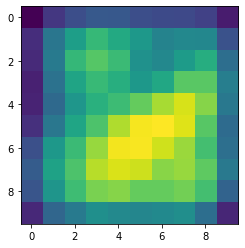

In [65]:
plt.imshow(inp_g.squeeze())

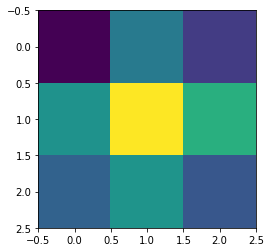

In [66]:
plt.imshow(w_g.squeeze())